In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import brier_score_loss
from sklearn import metrics
from sklearn import model_selection

from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition

import plotly.graph_objects as go
from sklearn.calibration import calibration_curve
import shap

import csv as csv
import pathlib
import warnings
#used for plots
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d

import os, json
import re

from mplsoccer import Pitch, VerticalPitch
from adjustText import adjust_text
from highlight_text import ax_text
from highlight_text import fig_text
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


import eli5
from eli5.sklearn import PermutationImportance
import tensorflow as tf
#tf.compat.v1.disable_v2_behavior()
import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

#Importing other libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#Importing libraries for model evaluation 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')



2024-06-18 14:19:07.304847: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
DIR = "/Users/aritramajumdar/Desktop/The_last_one/ShotData (1).csv"


In [3]:
def read_file(DIR):
    """
    Reads a CSV file from the given directory and returns a DataFrame.

    Parameters:
    DIR (str): Directory path of the CSV file.

    Returns:
    DataFrame: The read DataFrame.
    """
    df = pd.read_csv(DIR)
    return df

def preprocessing(df):
    """
    Preprocesses the DataFrame by adjusting coordinates and filtering for open play shots.
    It also maps shot outcomes to binary values.

    Parameters:
    df (DataFrame): The input DataFrame.

    Returns:
    DataFrame: The preprocessed DataFrame.
    """
    # Adjust coordinates
    df['x'] = 100.0 - df['position_x']
    df['y'] = 50.0 + df['position_y']
    
    # Filter for open play shots
    df = df.loc[df['play_type'] == 'Open Play']
    df = df.loc[df['outcome'] != 'owngoal']
    
    # Map shot outcomes to binary values
    df['shot_outcome'] = np.where((df['outcome'] == 'Goal'), 'Goal', 'No_Goal')
    mappings = {
        'Goal': 1,
        'No_Goal': 0
    }
    df['shot_outcome'] = df['shot_outcome'].map(mappings)
    
    return df

def distance_calculation(df):
    """
    Calculates distances from the shot location to the goal posts and goal on the field and adds them as new columns.

    Parameters:
    df (DataFrame): The input DataFrame.

    Returns:
    DataFrame: The DataFrame with new distance columns.
    """
    # Calculate distances to points (100, 46), (100, 54), and (100, 50)
    df['shot_a'] = np.sqrt((df['x']-100)**2 + (df['y']-46)**2) #Distance to the goal post located at (100, 46)
    df['shot_b'] = np.sqrt((df['x']-100)**2 + (df['y']-54)**2) #Distance to the goal post located at (100, 54)
    df['shot_c'] = np.sqrt((df['x']-100)**2 + (df['y']-50)**2) #Distance to the goal 

    # Round distances to 2 decimal places
    df['shot_a'] = df['shot_a'].round(2)
    df['shot_b'] = df['shot_b'].round(2)
    df['shot_c'] = df['shot_c'].round(2)

    return df

def angle_calculation(df):
    """
    Calculates the shot angle using the cosine rule and adds it as a new column.

    Parameters:
    df (DataFrame): The input DataFrame.

    Returns:
    DataFrame: The DataFrame with the new shot angle column.
    """
    df['shot_angle'] = np.arccos((df['shot_a']**2 + df['shot_b']**2 - 64) / (2 * df['shot_a'] * df['shot_b']))
    df['shot_angle'] = np.degrees(df['shot_angle'])
    df['shot_angle'] = df['shot_angle'].round(2)
    
    return df

def assign_zone(row):
    """
    Assigns a zone to each shot based on its x and y coordinates.

    Parameters:
    row (Series): A row from the DataFrame.

    Returns:
    str: The zone assigned to the shot.
    """
    x, y = row['x'], row['y']
    
    # Define zones based on x and y coordinates
    if 94 < x <= 100 and 46 <= y <= 54:
        return "Zone 1"
    elif 94 < x <= 100 and 54 < y <= 63:
        return "Zone 2"
    elif 94 < x <= 100 and 37 <= y < 46:
        return "Zone 3"
    elif 94 < x <= 100 and 19 <= y < 37:
        return "Zone 4"
    elif 94 < x <= 100 and 63 < y <= 81:
        return "Zone 5"
    elif 88 < x <= 94 and 46 <= y <= 54:
        return "Zone 6"
    elif 88 < x <= 94 and 54 < y <= 63:
        return "Zone 7"
    elif 88 < x <= 94 and 37 <= y < 46:
        return "Zone 8"
    elif 88 < x <= 94 and 19 <= y < 37:
        return "Zone 9"
    elif 88 < x <= 94 and 63 < y <= 81:
        return "Zone 10"
    elif 83 < x <= 88 and 46 <= y <= 54:
        return "Zone 11"
    elif 83 < x <= 88 and 54 < y <= 63:
        return "Zone 12"
    elif 83 < x <= 88 and 37 <= y < 46:
        return "Zone 13"
    elif 83 < x <= 88 and 19 <= y < 37:
        return "Zone 14"
    elif 83 < x <= 88 and 63 < y <= 81:
        return "Zone 15"
    elif 75 < x <= 83 and 37 <= y <= 50:
        return "Zone 16"
    elif 75 < x <= 83 and 50 <= y <= 63:
        return "Zone 17"
    elif 67 <= x <= 75 and 37 <= y < 50:
        return "Zone 18"
    elif 67 <= x <= 75 and 50 <= y <= 63:
        return "Zone 19"
    elif 67 <= x <= 83 and 19 <= y < 37:
        return "Zone 20"
    elif 67 <= x <= 83 and 63 < y <= 81:
        return "Zone 21"
    else:
        return "Other"

def drop_columns(df, unnescessary_columns):
    """
    Drops unnecessary columns from the DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame.
    unnescessary_columns (list): List of columns to drop.

    Returns:
    DataFrame: The DataFrame with specified columns dropped.
    """
    df = df.drop(unnescessary_columns, axis = 1)
    return df

def cat_to_num(df, fixed_bodypart_mapping, fixed_interference_mapping, fixed_zone_mapping):
    """
    Converts categorical columns to numerical using fixed mappings.

    Parameters:
    df (DataFrame): The input DataFrame.
    fixed_bodypart_mapping (dict): Mapping for BodyPart column.
    fixed_interference_mapping (dict): Mapping for Interference_on_Shooter column.
    fixed_zone_mapping (dict): Mapping for zone column.

    Returns:
    DataFrame: The DataFrame with categorical columns converted to numerical.
    """
    df['BodyPart'] = df['BodyPart'].map(fixed_bodypart_mapping)
    df['Interference_on_Shooter'] = df['Interference_on_Shooter'].map(fixed_interference_mapping)
    df['zone'] = df['zone'].map(fixed_zone_mapping)
    
    return df

def X_y(df, variables, target):
    """
    Splits the DataFrame into features (X) and target (y) variables.

    Parameters:
    df (DataFrame): The input DataFrame.
    variables (list): List of feature columns.
    target (str): The target column.

    Returns:
    DataFrame, Series: The feature DataFrame (X) and target Series (y).
    """
    X = df[variables]
    y = df[target]
    return X, y


In [4]:
def split(X, y, test_size=0.1):
    """
    Splits the dataset into training and test sets.

    Parameters:
    X (DataFrame): Features DataFrame.
    y (Series): Target variable.
    test_size (float): Proportion of the dataset to include in the test split.

    Returns:
    DataFrame, DataFrame, Series, Series: Training features, test features, training target, test target.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        stratify=y, random_state=2100)
    return X_train, X_test, y_train, y_test

def split_ANN(X, y, test_size=0.1):
    """
    Splits the dataset into training and test sets for ANN, converting to numpy arrays.

    Parameters:
    X (DataFrame): Features DataFrame.
    y (Series): Target variable.
    test_size (float): Proportion of the dataset to include in the test split.

    Returns:
    numpy.array, numpy.array, numpy.array, numpy.array: Training features, test features, training target, test target.
    """
    X = X.values
    y = y.values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        stratify=y, random_state=2100)
    return X_train, X_test, y_train, y_test

def scaler_transformation(X_train, X_test):
    """
    Scales the features using Min-Max scaling and returns the scaler along with scaled features.

    Parameters:
    X_train (DataFrame): Training features.
    X_test (DataFrame): Test features.

    Returns:
    MinMaxScaler, numpy.array, numpy.array: Fitted scaler, scaled training features, training target, scaled test features.
    """
    scaler = MinMaxScaler(feature_range=(0.01, 0.99)).fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    return scaler, X_train, X_test

def pca_transformation(X_train, X_test):
    """
    Applies PCA transformation to the features and returns the PCA model along with transformed features.

    Parameters:
    X_train (DataFrame): Training features.
    X_test (DataFrame): Test features.

    Returns:
    PCA, numpy.array, numpy.array: Fitted PCA model, PCA-transformed training features, training target, PCA-transformed test features.
    """
    pca = decomposition.PCA().fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    
    return pca, X_train, X_test


def sampling(X_train, y_train):
    """
    Applies SMOTE for oversampling the minority class in the training set.

    Parameters:
    X_train (DataFrame): Training features.
    y_train (Series): Training target.

    Returns:
    DataFrame, Series: Resampled training features and target.
    """
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    return X_train, y_train

def classifier_ML(model, X_train, y_train, X_test):
    """
    Trains a machine learning model and makes predictions on the test set.

    Parameters:
    model: Machine learning model.
    X_train (DataFrame): Training features.
    y_train (Series): Training target.
    X_test (DataFrame): Test features.

    Returns:
    model, numpy.array, numpy.array: Trained model, test predictions, test probabilities.
    """
    clf = model.fit(X_train, y_train)
    clf_preds = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    
    return clf, clf_preds, y_prob

def classifier_ANN(model, X_train, y_train, X_test, epochs, validation_split, batch_size, class_weight, shuffle):
    """
    Trains an artificial neural network (ANN) and makes predictions on the test set.

    Parameters:
    model: ANN model.
    X_train (numpy.array): Training features.
    y_train (numpy.array): Training target.
    X_test (numpy.array): Test features.
    epochs (int): Number of epochs to train.
    validation_split (float): Fraction of the training data to be used as validation data.
    batch_size (int): Number of samples per gradient update.
    class_weight (dict): Weights associated with classes.
    shuffle (bool): Whether to shuffle the training data before each epoch.

    Returns:
    history, numpy.array, numpy.array: Training history, test predictions, test probabilities.
    """
    history = model.fit(X_train, y_train,
                        epochs=epochs, validation_split=validation_split,
                        batch_size=batch_size, class_weight=class_weight, shuffle=shuffle, verbose=1)
    clf_preds = model.predict(X_test) > 0.5
    y_prob = model.predict(X_test).flatten()
    
    return history, clf_preds, y_prob

def evaluation_metrics(clf_preds, y_prob, y_test):
    """
    Evaluates the performance of the classifier using various metrics.

    Parameters:
    clf_preds (numpy.array): Predictions of the classifier.
    y_prob (numpy.array): Predicted probabilities.
    y_test (Series): True target values.

    Returns:
    None
    """
    cm = confusion_matrix(y_test, clf_preds)
    print(f"Confusion matrix of the classifier: \n{cm}")
    
    cr = classification_report(y_test, clf_preds)
    print(f"Classification report of the classifier: \n{cr}")
    
    roc_auc = roc_auc_score(y_test, clf_preds)
    print(f"ROC AUC score of the classifier: {roc_auc:.4f}")
    
    brier_base = brier_score_loss(y_test, y_prob)
    print(f"Brier score of the classifier: {brier_base:.4f}")
    
    rmse = np.sqrt(mean_squared_error(y_test, y_prob))
    print(f"RMSE of the classifier: {rmse:.4f}")
    
def prediction(test_X, test_y, preds):
    """
    Combines the test features, test labels, and predicted probabilities into a single DataFrame.

    Parameters:
    test_X (DataFrame): The test feature dataset.
    test_y (Series): The true labels of the test set.
    preds (array): The predicted probabilities of the positive class.

    Returns:
    DataFrame: A DataFrame combining the test features, true labels, and predicted probabilities.
    """
    # Combine the test features and true labels
    test_data = pd.concat([test_X, test_y], axis=1)
    
    # Reset the index of the combined dataset
    test_data = test_data.reset_index(drop=True)
    
    # Create a DataFrame for the predicted probabilities
    preds_data = pd.DataFrame(preds, columns=['xG'])
    
    # Combine the test dataset with the predicted probabilities
    prediction = pd.concat([test_data, preds_data], axis=1)
    
    return prediction



In [5]:
def loss_eval(history):
    """
    Plots the training and validation loss over epochs.

    Parameters:
    history: History object returned by the fit method of the ANN model.

    Returns:
    None
    """
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(1, len(loss_train) + 1)  # Adjust the range based on the length of history
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def accuracy_eval(history):
    """
    Plots the training and validation accuracy over epochs.

    Parameters:
    history: History object returned by the fit method of the ANN model.

    Returns:
    None
    """
    acc_train = history.history['accuracy']
    acc_val = history.history['val_accuracy']
    epochs = range(1, len(acc_train) + 1)  # Adjust the range based on the length of history
    plt.plot(epochs, acc_train, 'g', label='Training accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def cal_cur(pred, true, bins):
    """
    Plots the calibration curve and histogram of predicted probabilities.

    Parameters:
    pred (array): Predicted probabilities.
    true (array): True labels.
    bins (int): Number of bins to use for calibration curve.

    Returns:
    None
    """
    prob_true, prob_pred = calibration_curve(true, pred, n_bins=bins)

    fig = go.Figure()

    # Add calibration curve
    fig.add_trace(go.Scatter(x=prob_pred, y=prob_true, mode='markers+lines', name='Model',
                             line=dict(color='blue'), marker=dict(size=8)))

    # Add perfectly calibrated line
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Perfectly Calibrated',
                             line=dict(dash='dash', color='gray')))

    # Add histogram
    fig.add_trace(go.Histogram(x=pred, nbinsx=bins, name='Predicted Probabilities',
                               marker_color='red', opacity=0.4, yaxis='y2'))

    # Update layout for dual y-axes
    fig.update_layout(
        title='Calibration Curve with Histogram',
        xaxis_title='Mean Predicted Probability',
        yaxis_title='Fraction of Positives',
        yaxis2=dict(title='Count', overlaying='y', side='right'),
        legend=dict(x=0.01, y=0.99),
        bargap=0.1,
        hovermode='x'
    )

    fig.show()
    
def calibration(pred, true, bins):
    """
    Plots the calibration curve and histogram of predicted probabilities.

    Parameters:
    pred (array): Predicted probabilities.
    true (array): True labels.
    bins (int): Number of bins to use for calibration curve.

    Returns:
    None
    """
    prob_true, prob_pred = calibration_curve(true, pred, n_bins=bins)
    
    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Plot calibration curve
    ax1.plot(prob_pred, prob_true, marker='o', label='XGBoost', color='blue')
    ax1.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='gray')
    ax1.set_xlabel('Mean Predicted Probability')
    ax1.set_ylabel('Fraction of Positives')
    ax1.set_title('Calibration Curve with Histogram')
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # Plot histogram of predicted probabilities
    ax2 = ax1.twinx()
    ax2.hist(pred, bins=bins, range=(0, 1), alpha=0.4, color='red', edgecolor='black')
    ax2.set_ylabel('Count')
    
    plt.tight_layout()

    plt.savefig("/Users/aritramajumdar/Desktop/The_last_one/xgboost_calibration.png", dpi=300, bbox_inches='tight')

    plt.show()

def cal_shap_values(classifier, X_test):
    """
    Calculates SHAP values for the given classifier and test set.

    Parameters:
    classifier: Trained classifier.
    X_test (DataFrame): Test features.

    Returns:
    Explanation: SHAP values for the test set.
    """
    explainer = shap.Explainer(classifier)
    shap_values = explainer(X_test)
    return shap_values

def overall_feature_importance(shap_values):
    """
    Plots the overall feature importance based on SHAP values.

    Parameters:
    shap_values: SHAP values for the test set.

    Returns:
    None
    """
    shap.summary_plot(shap_values, X_test)
    shap.summary_plot(shap_values, X_test, plot_type="bar")

def single_instance_importance(shap_values, i):
    """
    Plots the SHAP values for a single instance and calculates the scoring chance.

    Parameters:
    shap_values: SHAP values for the test set.
    i (int): Index of the instance to plot.

    Returns:
    None
    """
    shap.plots.waterfall(shap_values[i])
    
    predicted = np.exp(shap_values[i].base_values + np.sum(shap_values[i].values))
    base = np.exp(shap_values[i].base_values)

    probability_pred = predicted / (1 + predicted)
    probability_base = base / (1 + base)
    
    print(f"The scoring chance predicted: {np.round((probability_pred * 100), 2)}%")
    print(f"The base scoring chance: {np.round((probability_base * 100), 2)}%")
    
    

def roc_curve_plot(test, prob, label):
    """
    Plots the ROC curve for the classifier's predicted probabilities.

    Parameters:
    test (array): True labels of the test set.
    prob (array): Predicted probabilities of the positive class.

    Returns:
    None
    """
    # Set the figure size for the plot
    sns.set(rc={'figure.figsize':(6, 4)})
    
    # Create a figure and axis for the plot
    fig, ax = plt.subplots()
    
    # Compute the false positive rate, true positive rate, and thresholds for the ROC curve
    fpr, tpr, thresholds = roc_curve(test, prob)
    
    # Plot the diagonal line representing random chance
    plt.plot([0, 1], [0, 1], 'k--')
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, marker='.', label=label)
    
    # Label the x-axis and y-axis
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Add a legend
    plt.legend()
    plt.tight_layout()

    plt.savefig("/Users/aritramajumdar/Desktop/The_last_one/xgboost_rocauc.png", dpi=300, bbox_inches='tight')
    
    # Display the plot
    plt.show()
    

def precision_recall_curve_plot(test, prob, y, label):
    """
    Plots the Precision-Recall curve for the classifier's predicted probabilities.

    Parameters:
    test (array): True labels of the test set.
    prob (array): Predicted probabilities of the positive class.
    y (array): True labels of the entire dataset (used to calculate the no skill line).

    Returns:
    None
    """
    # Set the figure size for the plot
    sns.set(rc={'figure.figsize':(6, 4)})
    
    # Create a figure and axis for the plot
    fig, ax = plt.subplots()
    
    # Calculate the no skill line as the proportion of the positive class
    no_skill = len(y[y == 1]) / len(y)
    
    # Plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    
    # Calculate model precision-recall curve
    precision, recall, _ = precision_recall_curve(test, prob)
    
    # Plot the model precision-recall curve
    plt.plot(recall, precision, marker='.', label=label)
    
    # Axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # Show the legend
    plt.legend()
    plt.tight_layout()

    plt.savefig("/Users/aritramajumdar/Desktop/The_last_one/xgboost_precrecall.png", dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()


def plot_shot_with_annotations(shot):
    """
    Plots shots on a vertical half-pitch with annotations for each shot's xG value.

    Parameters:
    shot (DataFrame): DataFrame containing shot data with columns 'x', 'y', and 'xG'.

    Returns:
    None
    """
    # Create figure and axis with specified background color
    fig, ax = plt.subplots(figsize=(12, 10), facecolor='linen')
    ax.axis('off')  # Turn off axis lines and labels
    
    # Create and draw the pitch
    pitch = VerticalPitch(pitch_type='opta', line_zorder=2, linewidth=0.5, line_color='black', half=True, goal_type='box')
    pitch.draw(ax=ax)
    
    # Plot the shots
    sc1 = pitch.scatter(shot.x, shot.y,
                        s=(shot.xG * 100) + 20,  # Scale shot sizes by xG value
                        c='#4682B4',  # Color of the shots
                        marker='o',  # Marker type
                        label="Open-play shots",  # Label for the legend
                        ax=ax)
    """
    # Annotate each shot's xG value
    for i, row in shot.iterrows():
        ax.annotate(f"{row['xG']:.2f}", (row['y'], row['x']), 
                    textcoords="offset points", xytext=(0, 10), ha='center', color='black')
    """
    
    # Display the plot
    plt.show()



def plot_shot(shots):
    """
    Plots shots on a full-pitch with annotations for each shot's xG value and corner points.

    Parameters:
    shots (DataFrame): DataFrame containing shot data with columns 'x', 'y', and 'xG'.

    Returns:
    None
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.axis('off')  # Turn off axis lines and labels

    # Create and draw the pitch
    pitch = Pitch(pitch_type='opta', pad_bottom=0.5, half=False, goal_type='box', goal_alpha=0.8, positional=True)
    pitch.draw(ax=ax)
    
    # Plot the starting positions of shots
    pitch.scatter(shots['x'], shots['y'], facecolors='red', s=(shots.xG * 100) + 20, 
                  edgecolors='#343434', linewidths=1, alpha=0.8, ax=ax)
    
    # Annotate each shot's xG value
    for i, row in shots.iterrows():
        ax.annotate(f"{row['xG']:.2f}", (row['x'], row['y']), textcoords="offset points", xytext=(0, 10), ha='center', color='black')
    
    # Define corner points and goal posts for annotation
    corner_points = [(0.0, 0.0), (100.0, 0.0), (0.0, 100.0), (100.0, 100.0),
                    (100.0, 46.0), (100.0, 54.0)]
    for (x, y) in corner_points:
        pitch.scatter(x, y, facecolors='orange', s=80, edgecolors='#343434', linewidths=1, alpha=0.8, ax=ax)
        ax.annotate(f"({x}, {y})", (x, y), textcoords="offset points", xytext=(0, 10), ha='center', color='black')
    
    # Display the plot
    plt.show()


In [6]:
"""------------------"""

# Reading and preprocessing the data
df = read_file(DIR)
df = preprocessing(df)
df = distance_calculation(df)
df = angle_calculation(df)
df['zone'] = df.apply(assign_zone, axis=1)

"""------------------"""

# Dropping unnecessary columns
unnescessary_columns = ['play_type', 'match_minute', 'match_second', 'position_x', 'position_y', 'outcome']
df = drop_columns(df, unnescessary_columns)

"""------------------"""

# Define fixed mappings for each unique value in the categorical columns
fixed_bodypart_mapping = {
    'Head': 1, 'Left': 2, 'Right': 3, 'Other': 4  # Example mappings, adjust according to actual unique values
}

fixed_interference_mapping = {
    'Low': 1, 'Medium': 2, 'High': 3  # Example mappings, adjust according to actual unique values
}

fixed_zone_mapping = {
    'Zone 1': 1, 'Zone 2': 2, 'Zone 3': 3, 'Zone 4': 4, 'Zone 5': 5, 'Zone 6': 6, 'Zone 7': 7,
    'Zone 8': 8, 'Zone 9': 9, 'Zone 10': 10, 'Zone 11': 11, 'Zone 12': 12, 'Zone 13': 13, 'Zone 14': 14,
    'Zone 15': 15, 'Zone 16': 16, 'Zone 17': 17, 'Zone 18': 18, 'Zone 19': 19, 'Zone 20': 20, 'Zone 21': 21,
    'Other': 22
}

# Save the mappings for future use
mappings = {
    'bodypart_mapping': fixed_bodypart_mapping,
    'interference_mapping': fixed_interference_mapping,
    'zone_mapping': fixed_zone_mapping
}

# Convert categorical columns to numerical
df = cat_to_num(df, fixed_bodypart_mapping, fixed_interference_mapping, fixed_zone_mapping)

"""------------------"""

# Define feature variables and target variable
variables = ['BodyPart', 'Number_Intervening_Opponents',
             'Number_Intervening_Teammates', 'Interference_on_Shooter',
             'x', 'y', 'shot_angle', 'shot_a', 'shot_b', 'shot_c', 'zone']
target = 'shot_outcome'

# Split the data into features and target
X, y = X_y(df, variables, target)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = split(X, y, test_size=0.1)

"""------------------"""

"""
X_train, y_train = sampling(X_train, y_train)
"""


'\nX_train, y_train = sampling(X_train, y_train)\n'

In [7]:
df

,BodyPart,Number_Intervening_Opponents,Number_Intervening_Teammates,Interference_on_Shooter,x,y,shot_outcome,shot_a,shot_b,shot_c,shot_angle,zone
0,1,1,0,1,96.76,49.25,1,4.59,5.75,3.33,100.78,1
1,2,3,0,2,75.06,50.75,0,25.39,25.15,24.95,18.21,17
2,3,1,0,1,96.26,49.50,0,5.12,5.85,3.77,93.41,1
4,1,1,0,1,89.77,54.99,0,13.62,10.28,11.38,35.78,7
5,3,3,1,2,75.81,50.75,0,24.65,24.41,24.20,18.76,17
...,...,...,...,...,...,...,...,...,...,...,...,...
10920,2,1,2,2,86.28,54.49,1,16.13,13.73,14.44,29.71,12
10921,1,1,0,2,90.52,56.24,1,13.95,9.74,11.35,33.93,7
10922,3,3,1,2,76.06,42.27,0,24.23,26.66,25.16,17.25,16
10923,2,2,0,2,79.05,58.23,0,24.26,21.37,22.51,18.86,17


In [8]:
df_final = df.copy()

df_final = df_final.sample(frac = 1) .reset_index(drop = True)
df_final["kfold"] = -1


kf = model_selection.StratifiedKFold(n_splits=10, shuffle=False)

for fold, (train_idx, val_idx) in enumerate(kf.split(X=df_final, y=df_final.shot_outcome.values)):  
    print(len(train_idx), len(val_idx))
    df_final.loc[val_idx, "kfold"] = fold

9203 1023
9203 1023
9203 1023
9203 1023
9203 1023
9203 1023
9204 1022
9204 1022
9204 1022
9204 1022


In [9]:
def model_ANN(input_dim, initial_learning_rate, initializer):
    
    initializer = initializer
    initial_learning_rate = initial_learning_rate
    
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)


    model = Sequential()
    model.add(Dense(Layer_1, input_dim=input_dim, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.5))
    model.add(Dense(Layer_2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(Layer_3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(tf.keras.optimizers.Adam(learning_rate=lr_schedule),'binary_crossentropy',metrics=['accuracy'])
    
    return model

In [10]:
def model_building(fold, model, df, epochs, validation_split, batch_size, class_weight, shuffle, use_sampling=False):
    

    FOLD_MAPPPING = {
        0: [1, 2, 3, 4, 5, 6, 7, 8, 9],
        1: [0, 2, 3, 4, 5, 6, 7, 8, 9],
        2: [0, 1, 3, 4, 5, 6, 7, 8, 9],
        3: [0, 1, 2, 4, 5, 6, 7, 8, 9],
        4: [0, 1, 2, 3, 5, 6, 7, 8, 9],
        
        5: [0, 1, 2, 3, 4, 6, 7, 8, 9],
        6: [0, 1, 2, 3, 4, 5, 7, 8, 9],
        7: [0, 1, 2, 3, 4, 5, 6, 8, 9],
        8: [0, 1, 2, 3, 4, 5, 6, 7, 9],
        9: [0, 1, 2, 3, 4, 5, 6, 7, 8]
       
        }
    
    

    train_df = df_final[df_final.kfold.isin(FOLD_MAPPPING.get(fold))]
    valid_df = df_final[df_final.kfold==fold]

    ytrain = train_df.shot_outcome.values
    yvalid = valid_df.shot_outcome.values

    train_df = train_df.drop(["shot_outcome", "kfold"], axis=1)
    valid_df = valid_df.drop(["shot_outcome", "kfold"], axis=1)
    valid_df = valid_df[train_df.columns]

    train_df = train_df.values
    valid_df = valid_df.values
    
    scaler, train_df, valid_df = scaler_transformation(train_df, valid_df)
    
    if use_sampling:
        train_df, ytrain = sampling(train_df, ytrain)
    else:
        train_df, ytrain = train_df, ytrain
        
    
    history = model.fit(train_df, ytrain,
      epochs=epochs, validation_split = validation_split,
      batch_size=batch_size, class_weight = class_weight, shuffle=shuffle, verbose = 1)
    
    clf_preds = model.predict(valid_df) > 0.5
    y_prob = model.predict(valid_df).flatten()
  
    
    cm = confusion_matrix(yvalid, clf_preds)
    print(f"Confusion matrix of the classifier: \n {cm}")
    
    cr = classification_report(yvalid, clf_preds)
    print(f"Classification report of the classifier: \n{cr}")
    
    roc_auc = roc_auc_score(yvalid, clf_preds)
    print(f"ROCAUC score of the classifier: {roc_auc:.4f}")
    
    brier_base = brier_score_loss(yvalid, y_prob)
    print(f"Brier score of the classifier: {brier_base:.4f}")
    
    rmse = np.sqrt(mean_squared_error(yvalid, y_prob))
    print(f"RMSE of the classifier: {rmse:.4f}")
    
    
    prob_true, prob_pred = calibration_curve(yvalid, y_prob, n_bins=10)

    plt.figure(figsize=(10, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='XGBoost', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='gray')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    return roc_auc, brier_base, rmse

    

In [11]:
input_dim = len(df.columns) - 1
initial_learning_rate = 0.0001
#initializer = tf.keras.initializers.GlorotNormal()
initializer = tf.keras.initializers.GlorotUniform()
Layer_1 = 200
Layer_2 = 100
Layer_3 = 50

model_wo_Sampling = model_ANN(input_dim, initial_learning_rate, initializer)


epochs = 150
validation_split = 0.1
batch_size = 128

#class_weight = {0: 0.1, 1: 0.13}
class_weight = None
shuffle = False

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6629 - loss: 0.6464 - val_accuracy: 0.8903 - val_loss: 0.4921
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8775 - loss: 0.4830 - val_accuracy: 0.8903 - val_loss: 0.3694
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8884 - loss: 0.3885 - val_accuracy: 0.8903 - val_loss: 0.3322
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8883 - loss: 0.3555 - val_accuracy: 0.8903 - val_loss: 0.3253
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8890 - loss: 0.3569 - val_accuracy: 0.8903 - val_loss: 0.3208
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8890 - loss: 0.3475 - val_accuracy: 0.8903 - val_loss: 0.3169
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8889 - loss: 0.3387 - val_accuracy: 0.8903 - val_loss: 0.3137
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8890 - loss: 0.3309 - val_accuracy: 0.8903 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8908 - loss: 0.2949 - val_accuracy: 0.8936 - val_loss: 0.3050
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8921 - loss: 0.2960 - val_accuracy: 0.8936 - val_loss: 0.3051
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8910 - loss: 0.2974 - val_accuracy: 0.8936 - val_loss: 0.3050
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8915 - loss: 0.2978 - val_accuracy: 0.8936 - val_loss: 0.3051
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8919 - loss: 0.2942 - val_accuracy: 0.8947 - val_loss: 0.3054
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8929 - loss: 0.2955 - val_accuracy: 0.8936 - val_loss: 0.3053
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8911 - loss: 0.2933 - val_accuracy: 0.8936 - val_loss: 0.3051
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8954 - loss: 0.2939 - val_accuracy: 0.8936 -

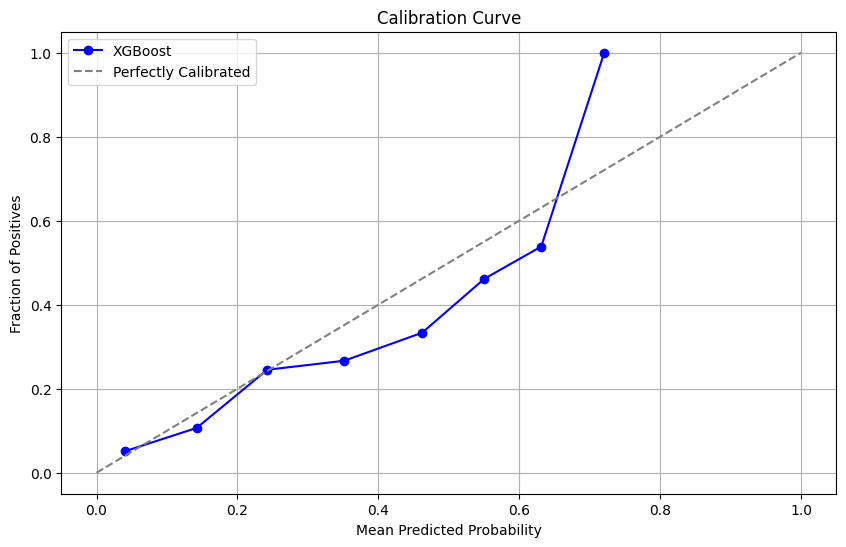

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8907 - loss: 0.2997 - val_accuracy: 0.8914 - val_loss: 0.3049
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8931 - loss: 0.2997 - val_accuracy: 0.8925 - val_loss: 0.3048
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8929 - loss: 0.3047 - val_accuracy: 0.8914 - val_loss: 0.3045
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8930 - loss: 0.3005 - val_accuracy: 0.8925 - val_loss: 0.3046
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8924 - loss: 0.3028 - val_accuracy: 0.8925 - val_loss: 0.3047
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8926 - loss: 0.3054 - val_accuracy: 0.8914 - val_loss: 0.3045
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8919 - loss: 0.2975 - val_accuracy: 0.8936 - val_loss: 0.3048
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8918 - loss: 0.2997 - val_accuracy: 0.8936 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8927 - loss: 0.2978 - val_accuracy: 0.8936 - val_loss: 0.3052
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8945 - loss: 0.2921 - val_accuracy: 0.8925 - val_loss: 0.3050
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8922 - loss: 0.2968 - val_accuracy: 0.8936 - val_loss: 0.3050
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8920 - loss: 0.2974 - val_accuracy: 0.8936 - val_loss: 0.3051
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8958 - loss: 0.2966 - val_accuracy: 0.8947 - val_loss: 0.3051
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8948 - loss: 0.2957 - val_accuracy: 0.8925 - val_loss: 0.3051
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8933 - loss: 0.2966 - val_accuracy: 0.8947 - val_loss: 0.3052
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8931 - loss: 0.2929 - val_accuracy: 0.8947 -

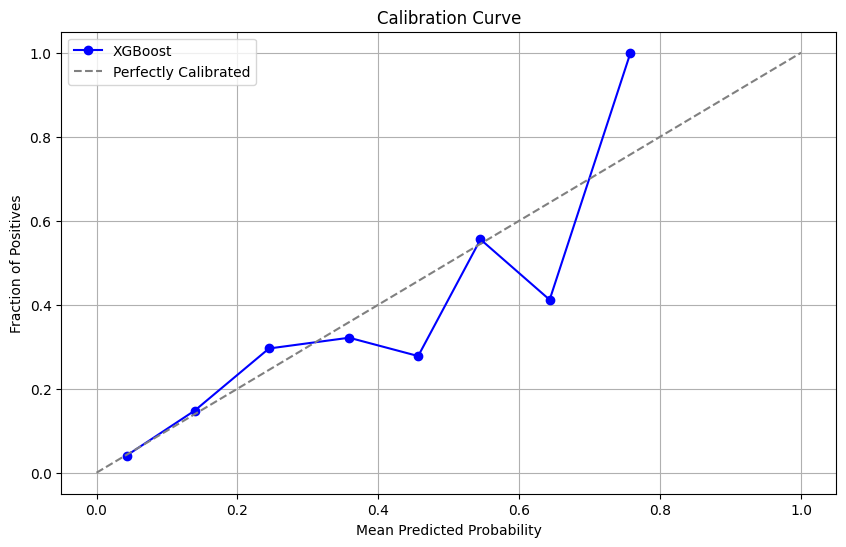

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8923 - loss: 0.2983 - val_accuracy: 0.8925 - val_loss: 0.3054
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8888 - loss: 0.2984 - val_accuracy: 0.8925 - val_loss: 0.3056
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8908 - loss: 0.2990 - val_accuracy: 0.8914 - val_loss: 0.3055
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8882 - loss: 0.2972 - val_accuracy: 0.8914 - val_loss: 0.3056
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8908 - loss: 0.2985 - val_accuracy: 0.8914 - val_loss: 0.3056
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8919 - loss: 0.2953 - val_accuracy: 0.8914 - val_loss: 0.3058
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8892 - loss: 0.3014 - val_accuracy: 0.8914 - val_loss: 0.3056
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8895 - loss: 0.2946 - val_accuracy: 0.8914 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8903 - loss: 0.2968 - val_accuracy: 0.8936 - val_loss: 0.3052
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8891 - loss: 0.2985 - val_accuracy: 0.8936 - val_loss: 0.3052
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8906 - loss: 0.2959 - val_accuracy: 0.8936 - val_loss: 0.3060
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8897 - loss: 0.2969 - val_accuracy: 0.8936 - val_loss: 0.3059
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8896 - loss: 0.2955 - val_accuracy: 0.8936 - val_loss: 0.3057
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8898 - loss: 0.2962 - val_accuracy: 0.8936 - val_loss: 0.3052
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8910 - loss: 0.2978 - val_accuracy: 0.8936 - val_loss: 0.3054
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8917 - loss: 0.2940 - val_accuracy: 0.8936 -

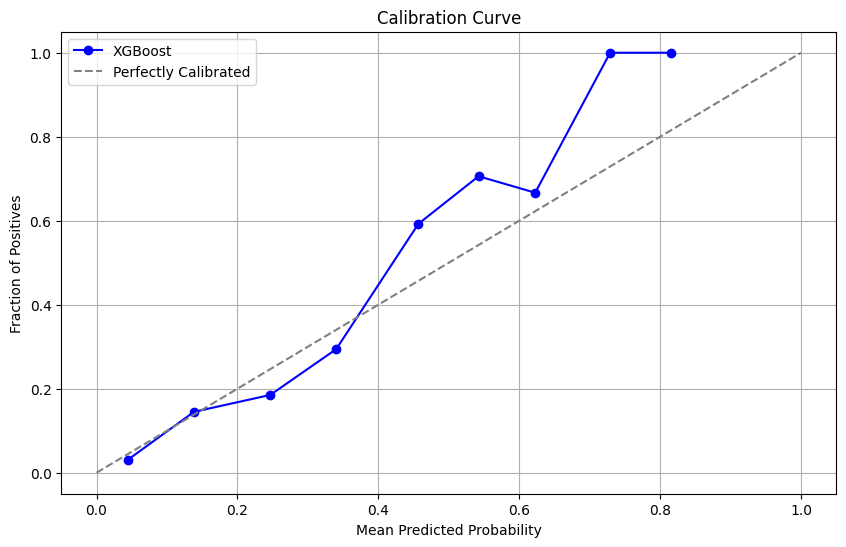

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8912 - loss: 0.2919 - val_accuracy: 0.8936 - val_loss: 0.3058
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8914 - loss: 0.2938 - val_accuracy: 0.8936 - val_loss: 0.3056
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8929 - loss: 0.2930 - val_accuracy: 0.8947 - val_loss: 0.3055
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8919 - loss: 0.2923 - val_accuracy: 0.8936 - val_loss: 0.3056
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8911 - loss: 0.2935 - val_accuracy: 0.8947 - val_loss: 0.3057
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8927 - loss: 0.2927 - val_accuracy: 0.8936 - val_loss: 0.3057
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8935 - loss: 0.2912 - val_accuracy: 0.8936 - val_loss: 0.3056
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8928 - loss: 0.2956 - val_accuracy: 0.8925 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8926 - loss: 0.2912 - val_accuracy: 0.8914 - val_loss: 0.3071
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8943 - loss: 0.2904 - val_accuracy: 0.8914 - val_loss: 0.3073
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8925 - loss: 0.2892 - val_accuracy: 0.8914 - val_loss: 0.3073
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8930 - loss: 0.2938 - val_accuracy: 0.8914 - val_loss: 0.3070
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8934 - loss: 0.2921 - val_accuracy: 0.8914 - val_loss: 0.3076
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8937 - loss: 0.2927 - val_accuracy: 0.8914 - val_loss: 0.3075
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8910 - loss: 0.2889 - val_accuracy: 0.8914 - val_loss: 0.3073
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8939 - loss: 0.2886 - val_accuracy: 0.8914 -

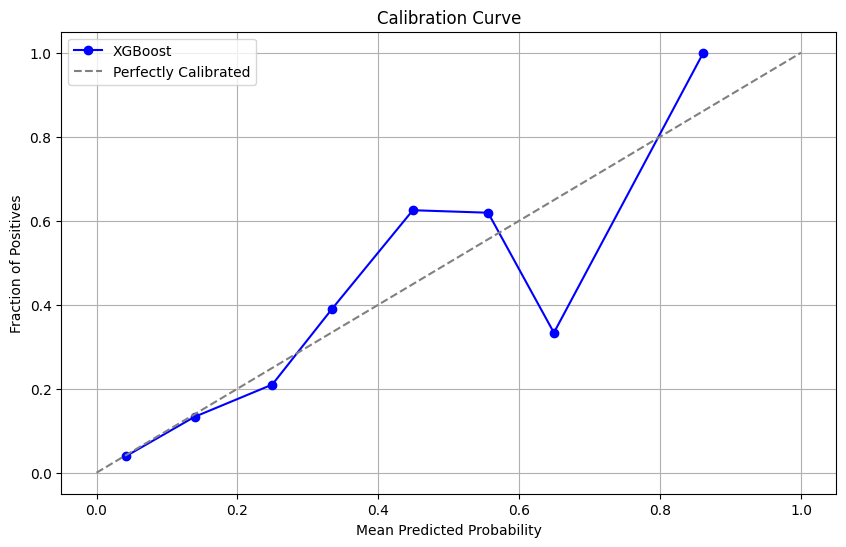

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8918 - loss: 0.2878 - val_accuracy: 0.8914 - val_loss: 0.3084
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8930 - loss: 0.2881 - val_accuracy: 0.8914 - val_loss: 0.3078
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8928 - loss: 0.2875 - val_accuracy: 0.8914 - val_loss: 0.3076
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8930 - loss: 0.2869 - val_accuracy: 0.8914 - val_loss: 0.3079
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8926 - loss: 0.2865 - val_accuracy: 0.8914 - val_loss: 0.3082
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8916 - loss: 0.2872 - val_accuracy: 0.8914 - val_loss: 0.3082
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8965 - loss: 0.2874 - val_accuracy: 0.8914 - val_loss: 0.3083
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8933 - loss: 0.2871 - val_accuracy: 0.8914 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8921 - loss: 0.2852 - val_accuracy: 0.8903 - val_loss: 0.3080
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8939 - loss: 0.2879 - val_accuracy: 0.8903 - val_loss: 0.3077
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8929 - loss: 0.2867 - val_accuracy: 0.8903 - val_loss: 0.3072
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8944 - loss: 0.2859 - val_accuracy: 0.8914 - val_loss: 0.3074
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8923 - loss: 0.2862 - val_accuracy: 0.8914 - val_loss: 0.3068
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8924 - loss: 0.2824 - val_accuracy: 0.8914 - val_loss: 0.3069
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8934 - loss: 0.2853 - val_accuracy: 0.8903 - val_loss: 0.3067
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8918 - loss: 0.2840 - val_accuracy: 0.8914 -

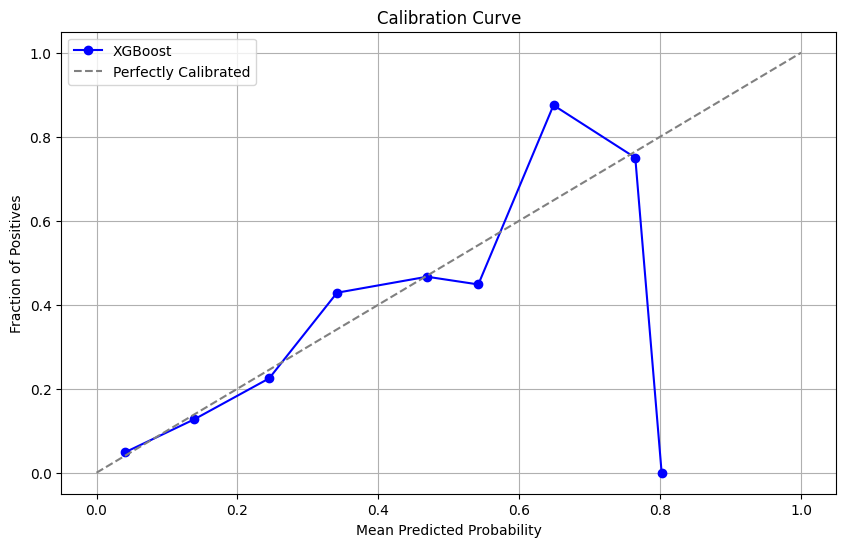

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8926 - loss: 0.2872 - val_accuracy: 0.8903 - val_loss: 0.3066
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8941 - loss: 0.2840 - val_accuracy: 0.8914 - val_loss: 0.3069
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8940 - loss: 0.2852 - val_accuracy: 0.8903 - val_loss: 0.3069
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8946 - loss: 0.2859 - val_accuracy: 0.8903 - val_loss: 0.3069
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8899 - loss: 0.2864 - val_accuracy: 0.8903 - val_loss: 0.3064
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8927 - loss: 0.2837 - val_accuracy: 0.8903 - val_loss: 0.3070
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8914 - loss: 0.2861 - val_accuracy: 0.8903 - val_loss: 0.3073
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8926 - loss: 0.2839 - val_accuracy: 0.8903 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8935 - loss: 0.2827 - val_accuracy: 0.8914 - val_loss: 0.3074
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8950 - loss: 0.2813 - val_accuracy: 0.8903 - val_loss: 0.3075
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8940 - loss: 0.2804 - val_accuracy: 0.8903 - val_loss: 0.3083
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8946 - loss: 0.2832 - val_accuracy: 0.8903 - val_loss: 0.3076
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8934 - loss: 0.2855 - val_accuracy: 0.8914 - val_loss: 0.3076
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8957 - loss: 0.2828 - val_accuracy: 0.8903 - val_loss: 0.3074
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8908 - loss: 0.2841 - val_accuracy: 0.8903 - val_loss: 0.3072
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8945 - loss: 0.2846 - val_accuracy: 0.8903 -

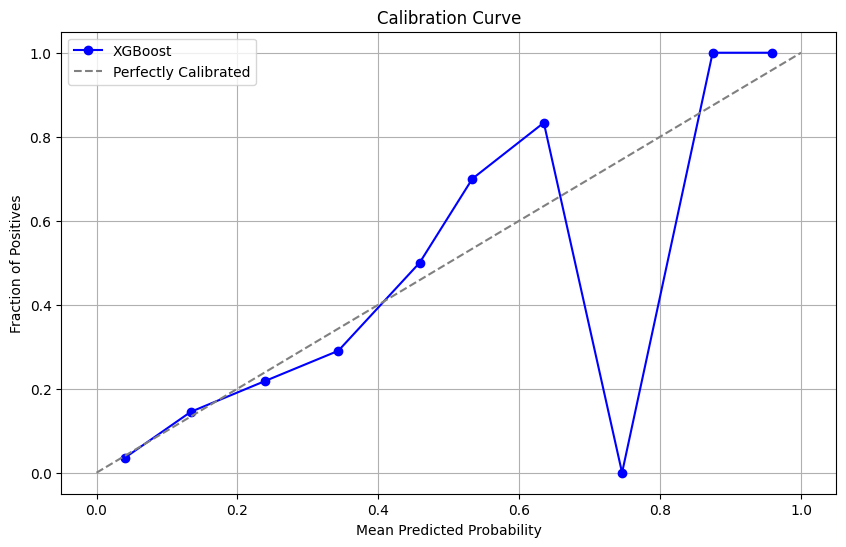

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8938 - loss: 0.2852 - val_accuracy: 0.8914 - val_loss: 0.3081
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8936 - loss: 0.2801 - val_accuracy: 0.8914 - val_loss: 0.3081
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8950 - loss: 0.2814 - val_accuracy: 0.8914 - val_loss: 0.3073
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8953 - loss: 0.2830 - val_accuracy: 0.8914 - val_loss: 0.3074
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8927 - loss: 0.2857 - val_accuracy: 0.8914 - val_loss: 0.3074
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8932 - loss: 0.2850 - val_accuracy: 0.8914 - val_loss: 0.3070
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8940 - loss: 0.2824 - val_accuracy: 0.8914 - val_loss: 0.3071
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8945 - loss: 0.2810 - val_accuracy: 0.8914 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8943 - loss: 0.2815 - val_accuracy: 0.8893 - val_loss: 0.3093
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8961 - loss: 0.2790 - val_accuracy: 0.8893 - val_loss: 0.3088
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8932 - loss: 0.2809 - val_accuracy: 0.8893 - val_loss: 0.3094
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8903 - loss: 0.2809 - val_accuracy: 0.8893 - val_loss: 0.3093
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8901 - loss: 0.2816 - val_accuracy: 0.8871 - val_loss: 0.3092
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8917 - loss: 0.2826 - val_accuracy: 0.8893 - val_loss: 0.3093
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8921 - loss: 0.2833 - val_accuracy: 0.8903 - val_loss: 0.3093
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8919 - loss: 0.2772 - val_accuracy: 0.8903 -

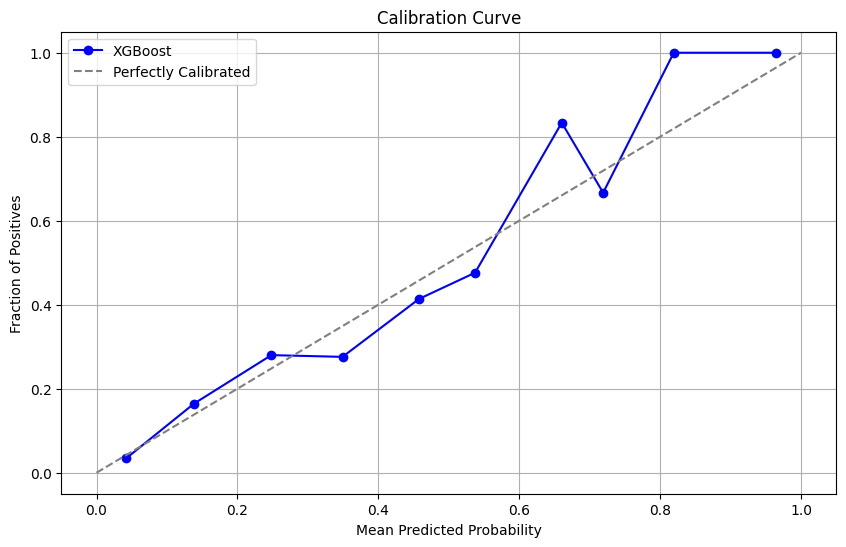

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8939 - loss: 0.2829 - val_accuracy: 0.8882 - val_loss: 0.3085
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8919 - loss: 0.2805 - val_accuracy: 0.8893 - val_loss: 0.3090
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8975 - loss: 0.2783 - val_accuracy: 0.8871 - val_loss: 0.3093
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8936 - loss: 0.2807 - val_accuracy: 0.8882 - val_loss: 0.3093
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8937 - loss: 0.2806 - val_accuracy: 0.8903 - val_loss: 0.3086
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8922 - loss: 0.2795 - val_accuracy: 0.8903 - val_loss: 0.3088
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8913 - loss: 0.2798 - val_accuracy: 0.8893 - val_loss: 0.3089
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8960 - loss: 0.2799 - val_accuracy: 0.8893 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8939 - loss: 0.2783 - val_accuracy: 0.8914 - val_loss: 0.3084
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8937 - loss: 0.2807 - val_accuracy: 0.8893 - val_loss: 0.3086
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8955 - loss: 0.2777 - val_accuracy: 0.8893 - val_loss: 0.3090
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8941 - loss: 0.2776 - val_accuracy: 0.8893 - val_loss: 0.3087
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8929 - loss: 0.2757 - val_accuracy: 0.8893 - val_loss: 0.3081
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8956 - loss: 0.2765 - val_accuracy: 0.8882 - val_loss: 0.3083
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8947 - loss: 0.2801 - val_accuracy: 0.8893 - val_loss: 0.3082
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8930 - loss: 0.2757 - val_accuracy: 0.8882 -

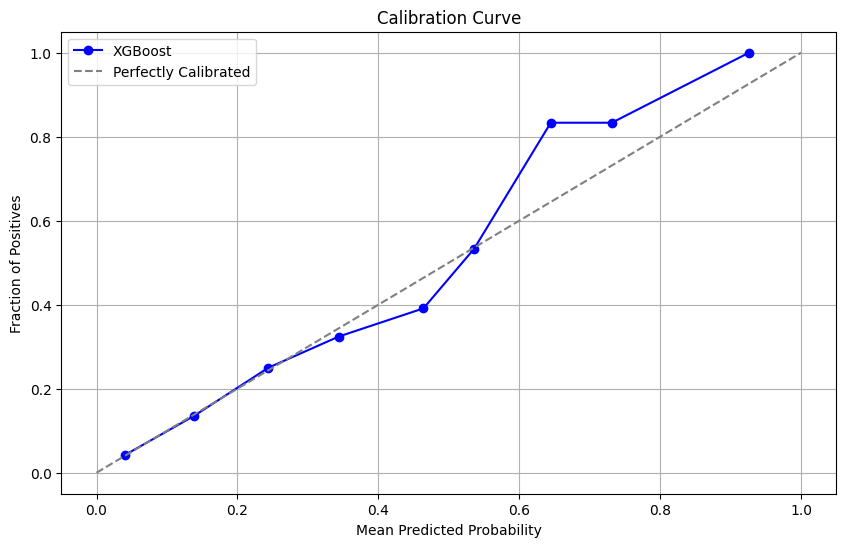

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8938 - loss: 0.2754 - val_accuracy: 0.8882 - val_loss: 0.3092
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8946 - loss: 0.2802 - val_accuracy: 0.8882 - val_loss: 0.3088
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8973 - loss: 0.2781 - val_accuracy: 0.8893 - val_loss: 0.3086
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8938 - loss: 0.2760 - val_accuracy: 0.8871 - val_loss: 0.3092
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8942 - loss: 0.2802 - val_accuracy: 0.8882 - val_loss: 0.3088
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8929 - loss: 0.2779 - val_accuracy: 0.8882 - val_loss: 0.3093
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8925 - loss: 0.2780 - val_accuracy: 0.8893 - val_loss: 0.3090
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8930 - loss: 0.2801 - val_accuracy: 0.8893 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8943 - loss: 0.2772 - val_accuracy: 0.8882 - val_loss: 0.3108
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8914 - loss: 0.2840 - val_accuracy: 0.8893 - val_loss: 0.3107
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8972 - loss: 0.2754 - val_accuracy: 0.8882 - val_loss: 0.3109
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8954 - loss: 0.2781 - val_accuracy: 0.8871 - val_loss: 0.3113
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8894 - loss: 0.2808 - val_accuracy: 0.8882 - val_loss: 0.3112
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8922 - loss: 0.2781 - val_accuracy: 0.8893 - val_loss: 0.3115
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8963 - loss: 0.2732 - val_accuracy: 0.8893 - val_loss: 0.3126
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8961 - loss: 0.2797 - val_accuracy: 0.8882 -

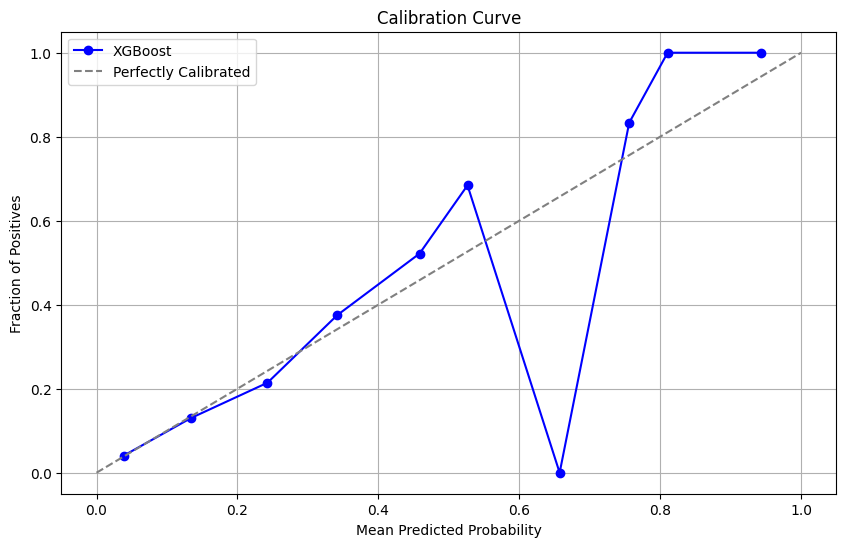

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8902 - loss: 0.2772 - val_accuracy: 0.9001 - val_loss: 0.2665
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8928 - loss: 0.2776 - val_accuracy: 0.9001 - val_loss: 0.2664
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8952 - loss: 0.2746 - val_accuracy: 0.8990 - val_loss: 0.2663
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8943 - loss: 0.2768 - val_accuracy: 0.8990 - val_loss: 0.2668
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8973 - loss: 0.2754 - val_accuracy: 0.8990 - val_loss: 0.2668
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8950 - loss: 0.2747 - val_accuracy: 0.9001 - val_loss: 0.2670
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8963 - loss: 0.2766 - val_accuracy: 0.8990 - val_loss: 0.2672
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8961 - loss: 0.2776 - val_accuracy: 0.9001 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8952 - loss: 0.2737 - val_accuracy: 0.8958 - val_loss: 0.2695
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8969 - loss: 0.2747 - val_accuracy: 0.8947 - val_loss: 0.2697
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8949 - loss: 0.2716 - val_accuracy: 0.8990 - val_loss: 0.2695
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8932 - loss: 0.2766 - val_accuracy: 0.8990 - val_loss: 0.2696
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8926 - loss: 0.2757 - val_accuracy: 0.8979 - val_loss: 0.2693
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8970 - loss: 0.2762 - val_accuracy: 0.8990 - val_loss: 0.2690
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8941 - loss: 0.2744 - val_accuracy: 0.8990 - val_loss: 0.2694
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8965 - loss: 0.2736 - val_accuracy: 0.8990 -

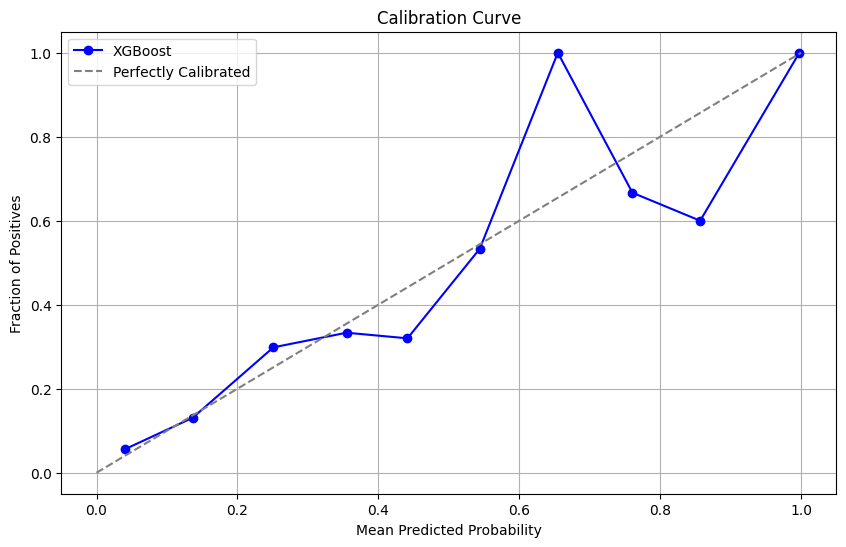

   fold   roc_auc  brier_base      rmse
0     0  0.587253    0.087709  0.296158
1     1  0.589540    0.087698  0.296138
2     2  0.593038    0.078325  0.279866
3     3  0.569641    0.081877  0.286142
4     4  0.586960    0.085368  0.292179
5     5  0.560244    0.082607  0.287414
6     6  0.574014    0.083602  0.289140
7     7  0.576224    0.082841  0.287822
8     8  0.584771    0.080820  0.284289
9     9  0.562851    0.089103  0.298501


In [12]:
results = []

for fold in range(10):
    roc_auc, brier_base, rmse = model_building(fold, model_wo_Sampling, df_final, epochs, validation_split, 
                                               batch_size, class_weight, shuffle, use_sampling=False)
    results.append({'fold': fold, 'roc_auc': roc_auc, 'brier_base': brier_base, 'rmse': rmse})

# Convert results to a DataFrame
results_df_without_sampling = pd.DataFrame(results)
print(results_df_without_sampling)

In [13]:
results_df_without_sampling

,fold,roc_auc,brier_base,rmse
0,0,0.587253,0.087709,0.296158
1,1,0.589540,0.087698,0.296138
2,2,0.593038,0.078325,0.279866
3,3,0.569641,0.081877,0.286142
4,4,0.586960,0.085368,0.292179
5,5,0.560244,0.082607,0.287414
6,6,0.574014,0.083602,0.289140
7,7,0.576224,0.082841,0.287822
8,8,0.584771,0.080820,0.284289
9,9,0.562851,0.089103,0.298501


In [16]:
input_dim = len(df.columns) - 1
initial_learning_rate = 0.0001
#initializer = tf.keras.initializers.GlorotNormal()
initializer = tf.keras.initializers.GlorotUniform()
Layer_1 = 200
Layer_2 = 100
Layer_3 = 50

model_cost_sensitive = model_ANN(input_dim, initial_learning_rate, initializer)


epochs = 150
validation_split = 0.1
batch_size = 128

class_weight = {0: 0.1, 1: 0.13}
#class_weight = 1.2
shuffle = False

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8968 - loss: 0.0319 - val_accuracy: 0.8893 - val_loss: 0.3127
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8989 - loss: 0.0317 - val_accuracy: 0.8882 - val_loss: 0.3128
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8970 - loss: 0.0319 - val_accuracy: 0.8882 - val_loss: 0.3129
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8961 - loss: 0.0319 - val_accuracy: 0.8871 - val_loss: 0.3131
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8954 - loss: 0.0319 - val_accuracy: 0.8871 - val_loss: 0.3131
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8925 - loss: 0.0321 - val_accuracy: 0.8860 - val_loss: 0.3132
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8989 - loss: 0.0314 - val_accuracy: 0.8860 - val_loss: 0.3136
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8970 - loss: 0.0317 - val_accuracy: 0.8860 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8972 - loss: 0.0316 - val_accuracy: 0.8827 - val_loss: 0.3147
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8991 - loss: 0.0312 - val_accuracy: 0.8827 - val_loss: 0.3150
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8980 - loss: 0.0316 - val_accuracy: 0.8827 - val_loss: 0.3159
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8961 - loss: 0.0318 - val_accuracy: 0.8838 - val_loss: 0.3155
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8969 - loss: 0.0315 - val_accuracy: 0.8827 - val_loss: 0.3151
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8965 - loss: 0.0314 - val_accuracy: 0.8827 - val_loss: 0.3159
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8925 - loss: 0.0321 - val_accuracy: 0.8806 - val_loss: 0.3144
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8969 - loss: 0.0319 - val_accuracy: 0.8827 -

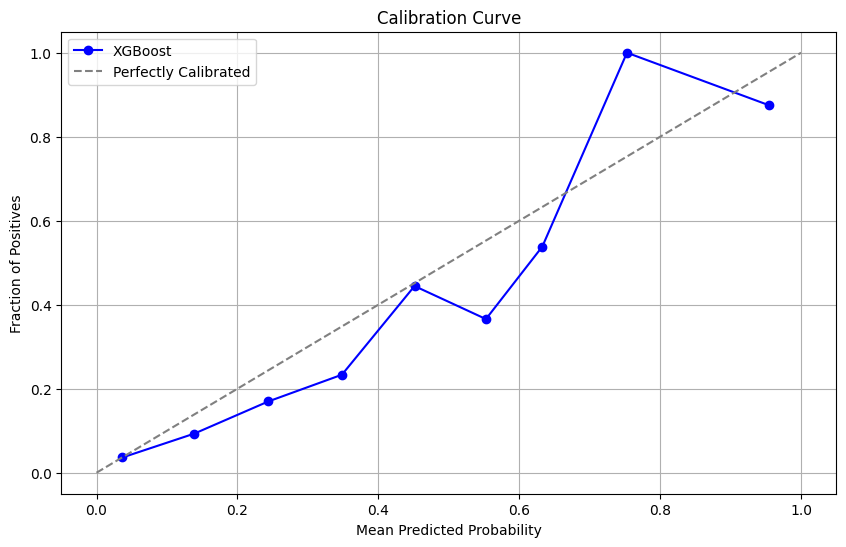

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8904 - loss: 0.0337 - val_accuracy: 0.8860 - val_loss: 0.3162
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8921 - loss: 0.0328 - val_accuracy: 0.8838 - val_loss: 0.3168
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8942 - loss: 0.0324 - val_accuracy: 0.8827 - val_loss: 0.3166
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8934 - loss: 0.0329 - val_accuracy: 0.8838 - val_loss: 0.3163
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8932 - loss: 0.0332 - val_accuracy: 0.8817 - val_loss: 0.3161
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8951 - loss: 0.0327 - val_accuracy: 0.8817 - val_loss: 0.3166
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8970 - loss: 0.0324 - val_accuracy: 0.8806 - val_loss: 0.3159
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8950 - loss: 0.0323 - val_accuracy: 0.8817 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8968 - loss: 0.0322 - val_accuracy: 0.8795 - val_loss: 0.3184
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8936 - loss: 0.0330 - val_accuracy: 0.8806 - val_loss: 0.3179
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8958 - loss: 0.0323 - val_accuracy: 0.8817 - val_loss: 0.3177
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8932 - loss: 0.0328 - val_accuracy: 0.8817 - val_loss: 0.3169
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8971 - loss: 0.0322 - val_accuracy: 0.8806 - val_loss: 0.3180
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8961 - loss: 0.0324 - val_accuracy: 0.8817 - val_loss: 0.3177
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8961 - loss: 0.0325 - val_accuracy: 0.8827 - val_loss: 0.3168
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8957 - loss: 0.0327 - val_accuracy: 0.8827 -

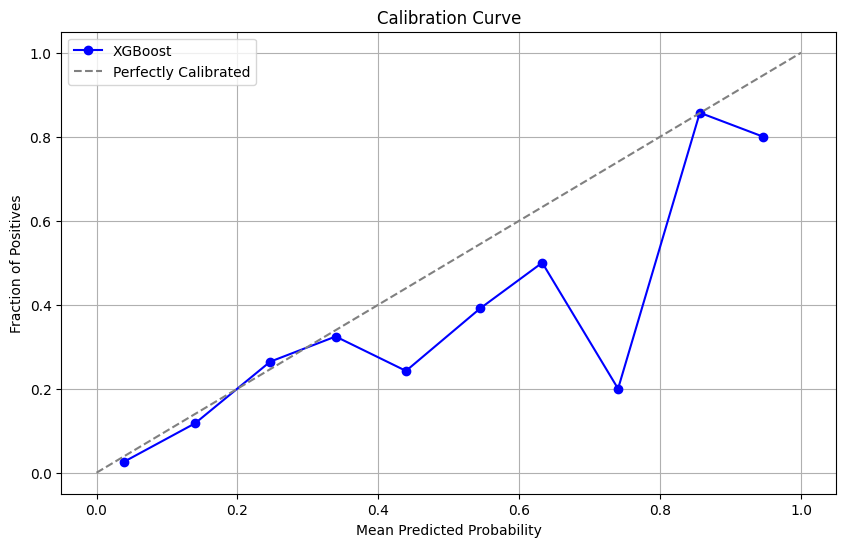

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8887 - loss: 0.0335 - val_accuracy: 0.8817 - val_loss: 0.3181
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8892 - loss: 0.0336 - val_accuracy: 0.8806 - val_loss: 0.3189
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8938 - loss: 0.0330 - val_accuracy: 0.8838 - val_loss: 0.3165
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8900 - loss: 0.0330 - val_accuracy: 0.8849 - val_loss: 0.3172
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8911 - loss: 0.0333 - val_accuracy: 0.8838 - val_loss: 0.3171
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8893 - loss: 0.0334 - val_accuracy: 0.8849 - val_loss: 0.3163
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8930 - loss: 0.0330 - val_accuracy: 0.8817 - val_loss: 0.3174
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8921 - loss: 0.0338 - val_accuracy: 0.8827 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8908 - loss: 0.0331 - val_accuracy: 0.8817 - val_loss: 0.3180
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8900 - loss: 0.0329 - val_accuracy: 0.8827 - val_loss: 0.3184
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8875 - loss: 0.0333 - val_accuracy: 0.8838 - val_loss: 0.3190
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8931 - loss: 0.0326 - val_accuracy: 0.8827 - val_loss: 0.3196
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8901 - loss: 0.0331 - val_accuracy: 0.8838 - val_loss: 0.3200
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8908 - loss: 0.0330 - val_accuracy: 0.8838 - val_loss: 0.3198
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8871 - loss: 0.0329 - val_accuracy: 0.8827 - val_loss: 0.3194
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8905 - loss: 0.0330 - val_accuracy: 0.8827 -

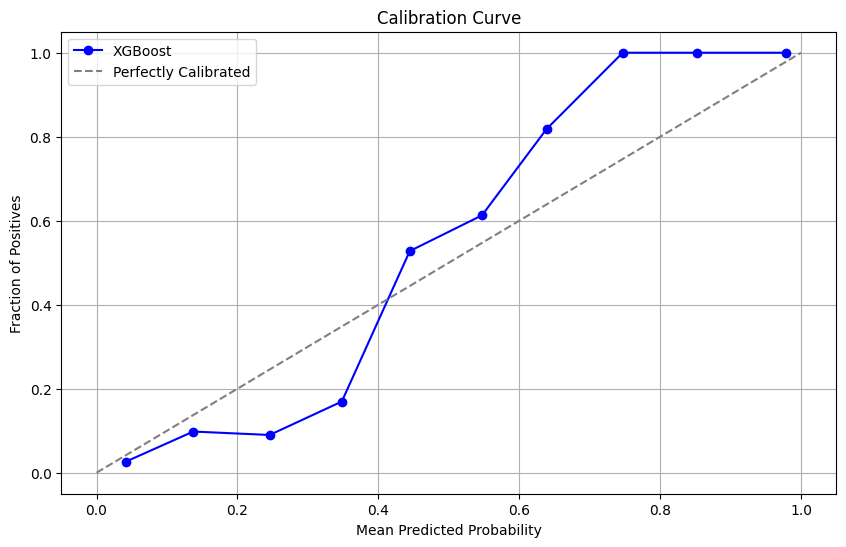

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8944 - loss: 0.0324 - val_accuracy: 0.8838 - val_loss: 0.3204
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8966 - loss: 0.0325 - val_accuracy: 0.8838 - val_loss: 0.3198
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8932 - loss: 0.0330 - val_accuracy: 0.8849 - val_loss: 0.3186
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8883 - loss: 0.0324 - val_accuracy: 0.8849 - val_loss: 0.3177
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8945 - loss: 0.0326 - val_accuracy: 0.8838 - val_loss: 0.3184
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8912 - loss: 0.0329 - val_accuracy: 0.8838 - val_loss: 0.3194
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8920 - loss: 0.0325 - val_accuracy: 0.8838 - val_loss: 0.3196
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8951 - loss: 0.0329 - val_accuracy: 0.8827 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8928 - loss: 0.0326 - val_accuracy: 0.8806 - val_loss: 0.3229
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8955 - loss: 0.0320 - val_accuracy: 0.8817 - val_loss: 0.3226
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8947 - loss: 0.0323 - val_accuracy: 0.8806 - val_loss: 0.3222
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8921 - loss: 0.0327 - val_accuracy: 0.8817 - val_loss: 0.3214
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8926 - loss: 0.0325 - val_accuracy: 0.8838 - val_loss: 0.3207
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8914 - loss: 0.0327 - val_accuracy: 0.8860 - val_loss: 0.3209
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8948 - loss: 0.0322 - val_accuracy: 0.8827 - val_loss: 0.3225
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8960 - loss: 0.0320 - val_accuracy: 0.8827 -

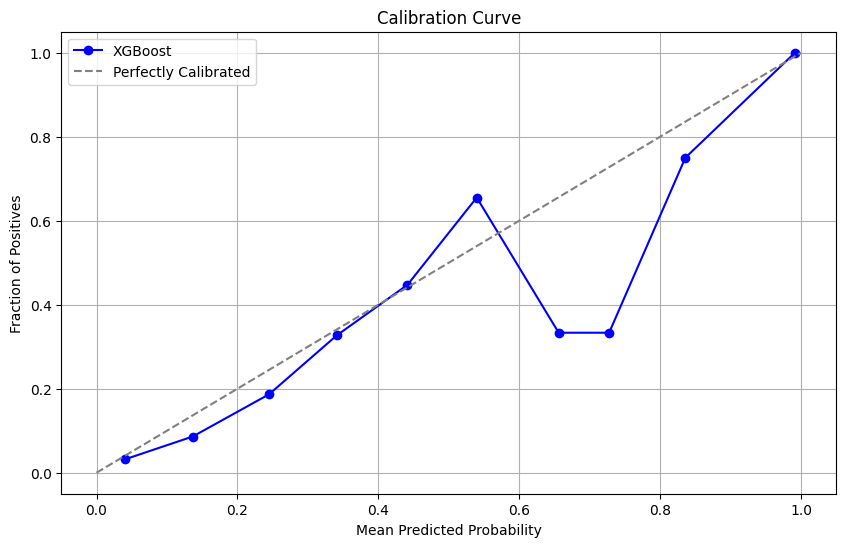

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8933 - loss: 0.0330 - val_accuracy: 0.8817 - val_loss: 0.3243
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8936 - loss: 0.0323 - val_accuracy: 0.8806 - val_loss: 0.3245
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8929 - loss: 0.0323 - val_accuracy: 0.8827 - val_loss: 0.3231
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8947 - loss: 0.0318 - val_accuracy: 0.8849 - val_loss: 0.3230
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8958 - loss: 0.0326 - val_accuracy: 0.8838 - val_loss: 0.3228
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8954 - loss: 0.0325 - val_accuracy: 0.8806 - val_loss: 0.3236
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8964 - loss: 0.0323 - val_accuracy: 0.8838 - val_loss: 0.3229
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8956 - loss: 0.0322 - val_accuracy: 0.8849 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8945 - loss: 0.0321 - val_accuracy: 0.8827 - val_loss: 0.3216
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8936 - loss: 0.0322 - val_accuracy: 0.8806 - val_loss: 0.3224
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8945 - loss: 0.0324 - val_accuracy: 0.8860 - val_loss: 0.3223
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8944 - loss: 0.0323 - val_accuracy: 0.8838 - val_loss: 0.3231
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8948 - loss: 0.0324 - val_accuracy: 0.8827 - val_loss: 0.3222
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8939 - loss: 0.0322 - val_accuracy: 0.8806 - val_loss: 0.3233
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8957 - loss: 0.0320 - val_accuracy: 0.8817 - val_loss: 0.3229
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8976 - loss: 0.0319 - val_accuracy: 0.8817 -

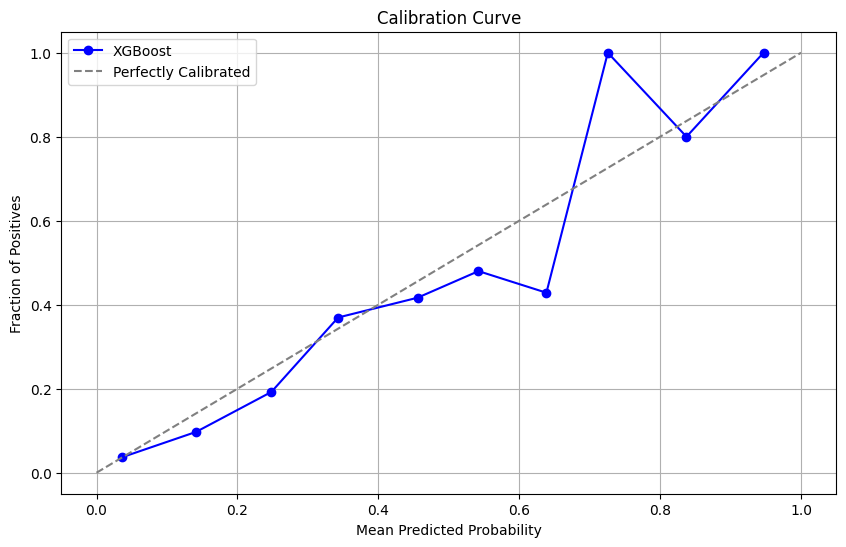

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8905 - loss: 0.0324 - val_accuracy: 0.8849 - val_loss: 0.3215
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8903 - loss: 0.0327 - val_accuracy: 0.8860 - val_loss: 0.3218
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8956 - loss: 0.0321 - val_accuracy: 0.8827 - val_loss: 0.3224
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8972 - loss: 0.0322 - val_accuracy: 0.8871 - val_loss: 0.3221
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8972 - loss: 0.0321 - val_accuracy: 0.8849 - val_loss: 0.3223
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8970 - loss: 0.0323 - val_accuracy: 0.8827 - val_loss: 0.3226
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8914 - loss: 0.0324 - val_accuracy: 0.8838 - val_loss: 0.3216
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8958 - loss: 0.0321 - val_accuracy: 0.8838 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8946 - loss: 0.0319 - val_accuracy: 0.8817 - val_loss: 0.3222
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8973 - loss: 0.0316 - val_accuracy: 0.8817 - val_loss: 0.3235
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8936 - loss: 0.0319 - val_accuracy: 0.8795 - val_loss: 0.3245
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8931 - loss: 0.0318 - val_accuracy: 0.8817 - val_loss: 0.3233
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8926 - loss: 0.0320 - val_accuracy: 0.8795 - val_loss: 0.3224
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8969 - loss: 0.0319 - val_accuracy: 0.8827 - val_loss: 0.3228
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8964 - loss: 0.0317 - val_accuracy: 0.8827 - val_loss: 0.3235
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8903 - loss: 0.0321 - val_accuracy: 0.8827 -

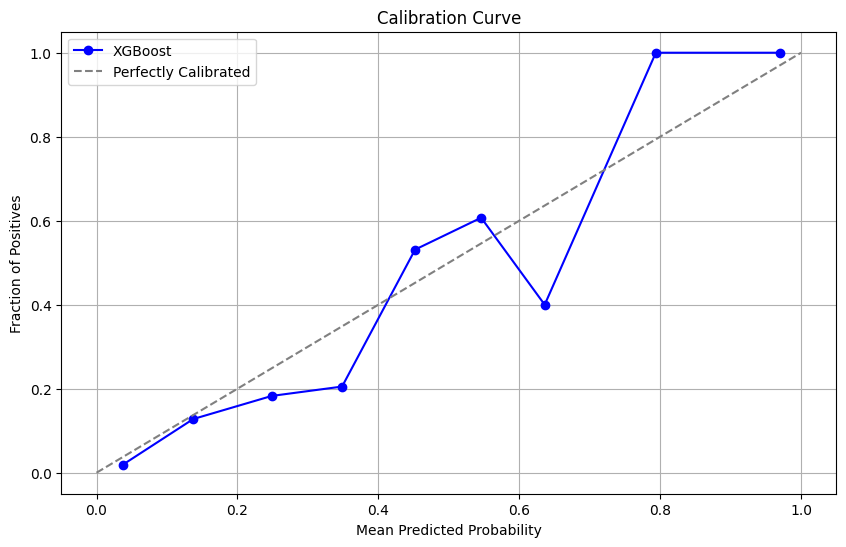

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8935 - loss: 0.0319 - val_accuracy: 0.8806 - val_loss: 0.3263
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8944 - loss: 0.0318 - val_accuracy: 0.8817 - val_loss: 0.3247
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8939 - loss: 0.0317 - val_accuracy: 0.8795 - val_loss: 0.3254
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8938 - loss: 0.0316 - val_accuracy: 0.8806 - val_loss: 0.3253
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8960 - loss: 0.0318 - val_accuracy: 0.8806 - val_loss: 0.3249
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8974 - loss: 0.0320 - val_accuracy: 0.8817 - val_loss: 0.3236
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8992 - loss: 0.0317 - val_accuracy: 0.8795 - val_loss: 0.3238
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8949 - loss: 0.0320 - val_accuracy: 0.8806 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8964 - loss: 0.0317 - val_accuracy: 0.8795 - val_loss: 0.3267
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8980 - loss: 0.0313 - val_accuracy: 0.8795 - val_loss: 0.3266
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8951 - loss: 0.0316 - val_accuracy: 0.8806 - val_loss: 0.3281
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8938 - loss: 0.0319 - val_accuracy: 0.8795 - val_loss: 0.3278
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8946 - loss: 0.0318 - val_accuracy: 0.8806 - val_loss: 0.3265
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8956 - loss: 0.0317 - val_accuracy: 0.8795 - val_loss: 0.3255
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8959 - loss: 0.0322 - val_accuracy: 0.8806 - val_loss: 0.3257
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8966 - loss: 0.0318 - val_accuracy: 0.8795 -

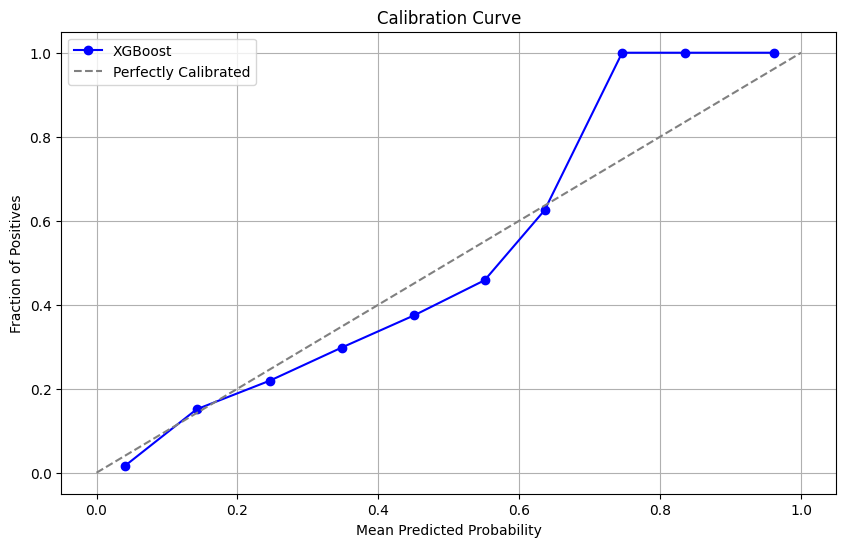

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8932 - loss: 0.0320 - val_accuracy: 0.8795 - val_loss: 0.3265
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8914 - loss: 0.0323 - val_accuracy: 0.8817 - val_loss: 0.3258
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8973 - loss: 0.0317 - val_accuracy: 0.8838 - val_loss: 0.3249
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8962 - loss: 0.0314 - val_accuracy: 0.8795 - val_loss: 0.3261
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8960 - loss: 0.0317 - val_accuracy: 0.8806 - val_loss: 0.3251
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9006 - loss: 0.0313 - val_accuracy: 0.8817 - val_loss: 0.3252
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8931 - loss: 0.0319 - val_accuracy: 0.8817 - val_loss: 0.3264
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8974 - loss: 0.0319 - val_accuracy: 0.8806 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8971 - loss: 0.0316 - val_accuracy: 0.8806 - val_loss: 0.3246
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8944 - loss: 0.0318 - val_accuracy: 0.8784 - val_loss: 0.3244
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8956 - loss: 0.0310 - val_accuracy: 0.8817 - val_loss: 0.3261
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8945 - loss: 0.0318 - val_accuracy: 0.8827 - val_loss: 0.3246
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8986 - loss: 0.0316 - val_accuracy: 0.8817 - val_loss: 0.3250
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8994 - loss: 0.0313 - val_accuracy: 0.8806 - val_loss: 0.3240
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8937 - loss: 0.0314 - val_accuracy: 0.8817 - val_loss: 0.3251
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8977 - loss: 0.0311 - val_accuracy: 0.8806 -

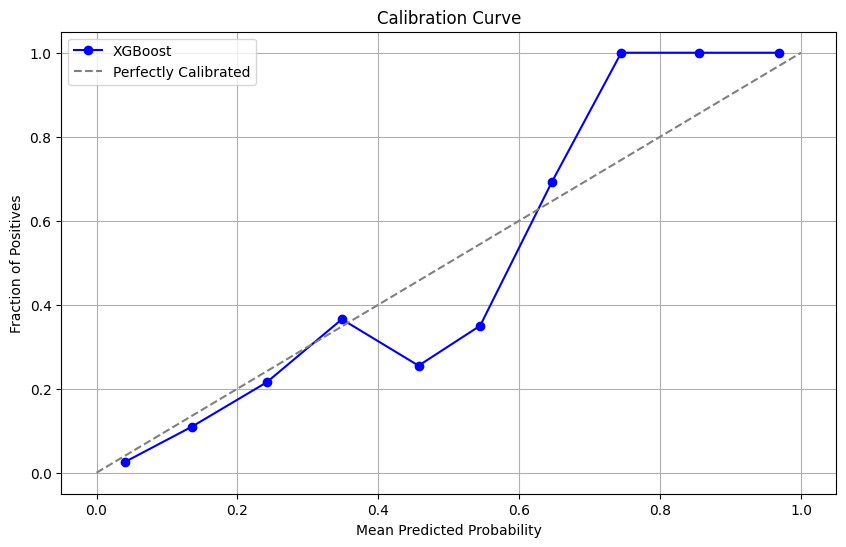

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8957 - loss: 0.0314 - val_accuracy: 0.8795 - val_loss: 0.3262
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8962 - loss: 0.0315 - val_accuracy: 0.8806 - val_loss: 0.3264
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8941 - loss: 0.0313 - val_accuracy: 0.8806 - val_loss: 0.3273
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8977 - loss: 0.0313 - val_accuracy: 0.8838 - val_loss: 0.3263
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8984 - loss: 0.0317 - val_accuracy: 0.8806 - val_loss: 0.3257
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8966 - loss: 0.0321 - val_accuracy: 0.8806 - val_loss: 0.3267
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8933 - loss: 0.0319 - val_accuracy: 0.8827 - val_loss: 0.3246
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8977 - loss: 0.0314 - val_accuracy: 0.8827 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8977 - loss: 0.0313 - val_accuracy: 0.8806 - val_loss: 0.3278
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8975 - loss: 0.0313 - val_accuracy: 0.8817 - val_loss: 0.3292
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8920 - loss: 0.0313 - val_accuracy: 0.8817 - val_loss: 0.3278
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8954 - loss: 0.0317 - val_accuracy: 0.8806 - val_loss: 0.3275
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8952 - loss: 0.0317 - val_accuracy: 0.8827 - val_loss: 0.3275
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8967 - loss: 0.0312 - val_accuracy: 0.8806 - val_loss: 0.3272
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8982 - loss: 0.0313 - val_accuracy: 0.8827 - val_loss: 0.3277
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8949 - loss: 0.0316 - val_accuracy: 0.8838 -

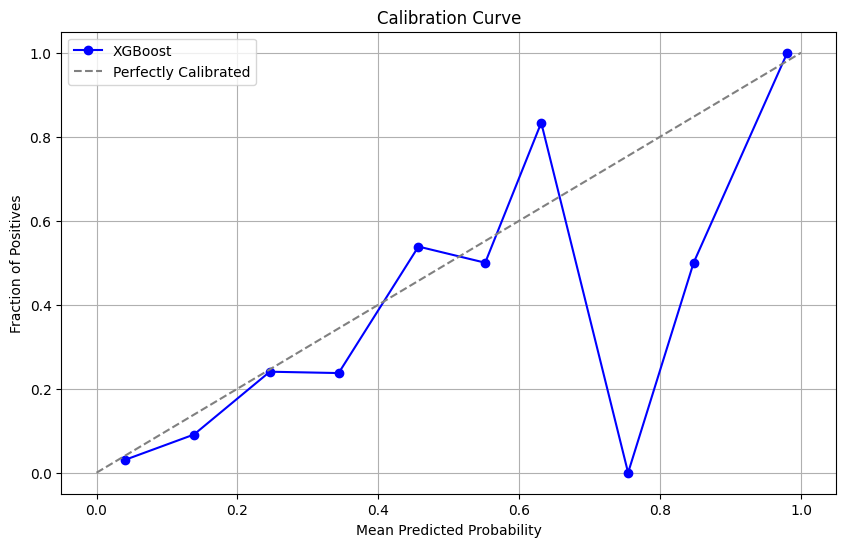

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8963 - loss: 0.0314 - val_accuracy: 0.8990 - val_loss: 0.2608
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8951 - loss: 0.0317 - val_accuracy: 0.9001 - val_loss: 0.2627
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8956 - loss: 0.0316 - val_accuracy: 0.9001 - val_loss: 0.2629
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8998 - loss: 0.0311 - val_accuracy: 0.8990 - val_loss: 0.2624
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8978 - loss: 0.0310 - val_accuracy: 0.8979 - val_loss: 0.2624
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8988 - loss: 0.0309 - val_accuracy: 0.8969 - val_loss: 0.2631
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8929 - loss: 0.0321 - val_accuracy: 0.8979 - val_loss: 0.2638
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8965 - loss: 0.0317 - val_accuracy: 0.8979 - v

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8979 - loss: 0.0311 - val_accuracy: 0.8958 - val_loss: 0.2653
Epoch 102/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8921 - loss: 0.0320 - val_accuracy: 0.8969 - val_loss: 0.2664
Epoch 103/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8973 - loss: 0.0316 - val_accuracy: 0.8979 - val_loss: 0.2655
Epoch 104/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8931 - loss: 0.0314 - val_accuracy: 0.8979 - val_loss: 0.2663
Epoch 105/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8960 - loss: 0.0311 - val_accuracy: 0.8969 - val_loss: 0.2657
Epoch 106/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8929 - loss: 0.0317 - val_accuracy: 0.8969 - val_loss: 0.2656
Epoch 107/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8931 - loss: 0.0309 - val_accuracy: 0.9001 - val_loss: 0.2647
Epoch 108/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8931 - loss: 0.0315 - val_accuracy: 0.8990 -

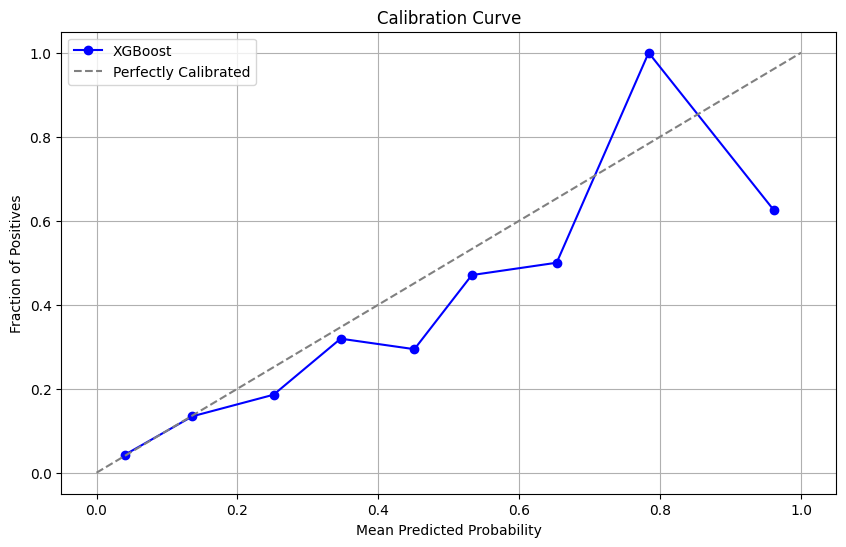

   fold   roc_auc  brier_base      rmse
0     0  0.614267    0.086294  0.293758
1     1  0.614229    0.086206  0.293609
2     2  0.670231    0.073299  0.270739
3     3  0.613489    0.079339  0.281671
4     4  0.614964    0.081115  0.284807
5     5  0.602435    0.080654  0.283997
6     6  0.593724    0.080414  0.283573
7     7  0.614539    0.080419  0.283583
8     8  0.591108    0.079228  0.281475
9     9  0.575525    0.090863  0.301435


In [17]:
results_cs = []

for fold in range(10):
    roc_auc, brier_base, rmse = model_building(fold, model_wo_Sampling, df_final, epochs, validation_split, 
                                               batch_size, class_weight, shuffle, use_sampling=False)
    results_cs.append({'fold': fold, 'roc_auc': roc_auc, 'brier_base': brier_base, 'rmse': rmse})

# Convert results to a DataFrame
results_df_with_cost_sensitive = pd.DataFrame(results_cs)
print(results_df_with_cost_sensitive)

In [18]:
results_df_with_cost_sensitive

,fold,roc_auc,brier_base,rmse
0,0,0.614267,0.086294,0.293758
1,1,0.614229,0.086206,0.293609
2,2,0.670231,0.073299,0.270739
3,3,0.613489,0.079339,0.281671
4,4,0.614964,0.081115,0.284807
5,5,0.602435,0.080654,0.283997
6,6,0.593724,0.080414,0.283573
7,7,0.614539,0.080419,0.283583
8,8,0.591108,0.079228,0.281475
9,9,0.575525,0.090863,0.301435


In [19]:
print("ANN without sampling")
print(f"Mean ROC-AUC Score: {results_df_without_sampling['roc_auc'].mean().round(3)}")
print(f"Mean Brier Score: {results_df_without_sampling['brier_base'].mean().round(3)}")
print(f"Mean RMSE Score: {results_df_without_sampling['rmse'].mean().round(3)}")

ANN without sampling
Mean ROC-AUC Score: 0.578
Mean Brier Score: 0.084
Mean RMSE Score: 0.29


In [20]:
print("Cost sensitive ANN")
print(f"Mean ROC-AUC Score: {results_df_with_cost_sensitive['roc_auc'].mean().round(3)}")
print(f"Mean Brier Score: {results_df_with_cost_sensitive['brier_base'].mean().round(3)}")
print(f"Mean RMSE Score: {results_df_with_cost_sensitive['rmse'].mean().round(3)}")

Cost sensitive ANN
Mean ROC-AUC Score: 0.61
Mean Brier Score: 0.082
Mean RMSE Score: 0.286
